In [1]:
# importing packages and modules
import numpy as np
#import autograd.numpy as jnp
import matplotlib as mpl
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1, dglm_hmm2
from scipy.stats import multivariate_normal, norm
#from autograd import value_and_grad

#colormap = ['rebeccapurple','teal','darkturquoise','springgreen']
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen']
sns.set_context("talk")

In [2]:
# CREATING COLORMAPS FOR RED AND BLUE
n_lines = 4
x = np.linspace(0, 10, 100)
y = np.sin(x[:, None] + np.pi * np.linspace(0, 1, n_lines))
c = np.arange(1, n_lines + 1)

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmapBlue = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)
cmapBlue.set_array([])

# fig, ax = plt.subplots(dpi=100)
# for i, yi in enumerate(y.T):
#    ax.plot(x, yi, c=cmapBlue.to_rgba(i + 2))
# fig.colorbar(cmapBlue, ticks=c)
# plt.show()

norm = mpl.colors.Normalize(vmin=c.min(), vmax=c.max())
cmapRed = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmapRed.set_array([])

# fig, ax = plt.subplots(dpi=100)
# for i, yi in enumerate(y.T):
#    ax.plot(x, yi, c=cmapRed.to_rgba(i + 1))
# fig.colorbar(cmapRed, ticks=c)
# plt.show()

In [3]:
# setting hyperparameters
S = 20 # sessions
T = 1000 # trials per session
N = T * S # total data points
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
# true intial latent state distribution
truepi = np.ones((K))/K
print(truepi)

[0.5 0.5]


In [4]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = 0 # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)
print("Session indicies")
print(sessInd)


Session indicies
[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


In [5]:
# True Transition Matrix
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95


In [16]:
dGLM_HMM = dglm_hmm1.dGLM_HMM1(N,K,D,C)
# x, y, _ = dGLM_HMM.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'/N={N}_{K}_state_constant-drift_')
x = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_x.npy')
y = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_y.npy')
z = np.load(f'../data_M1/N={N}_{K}_state_constant-drift_z.npy')

Best sigma =  0.125


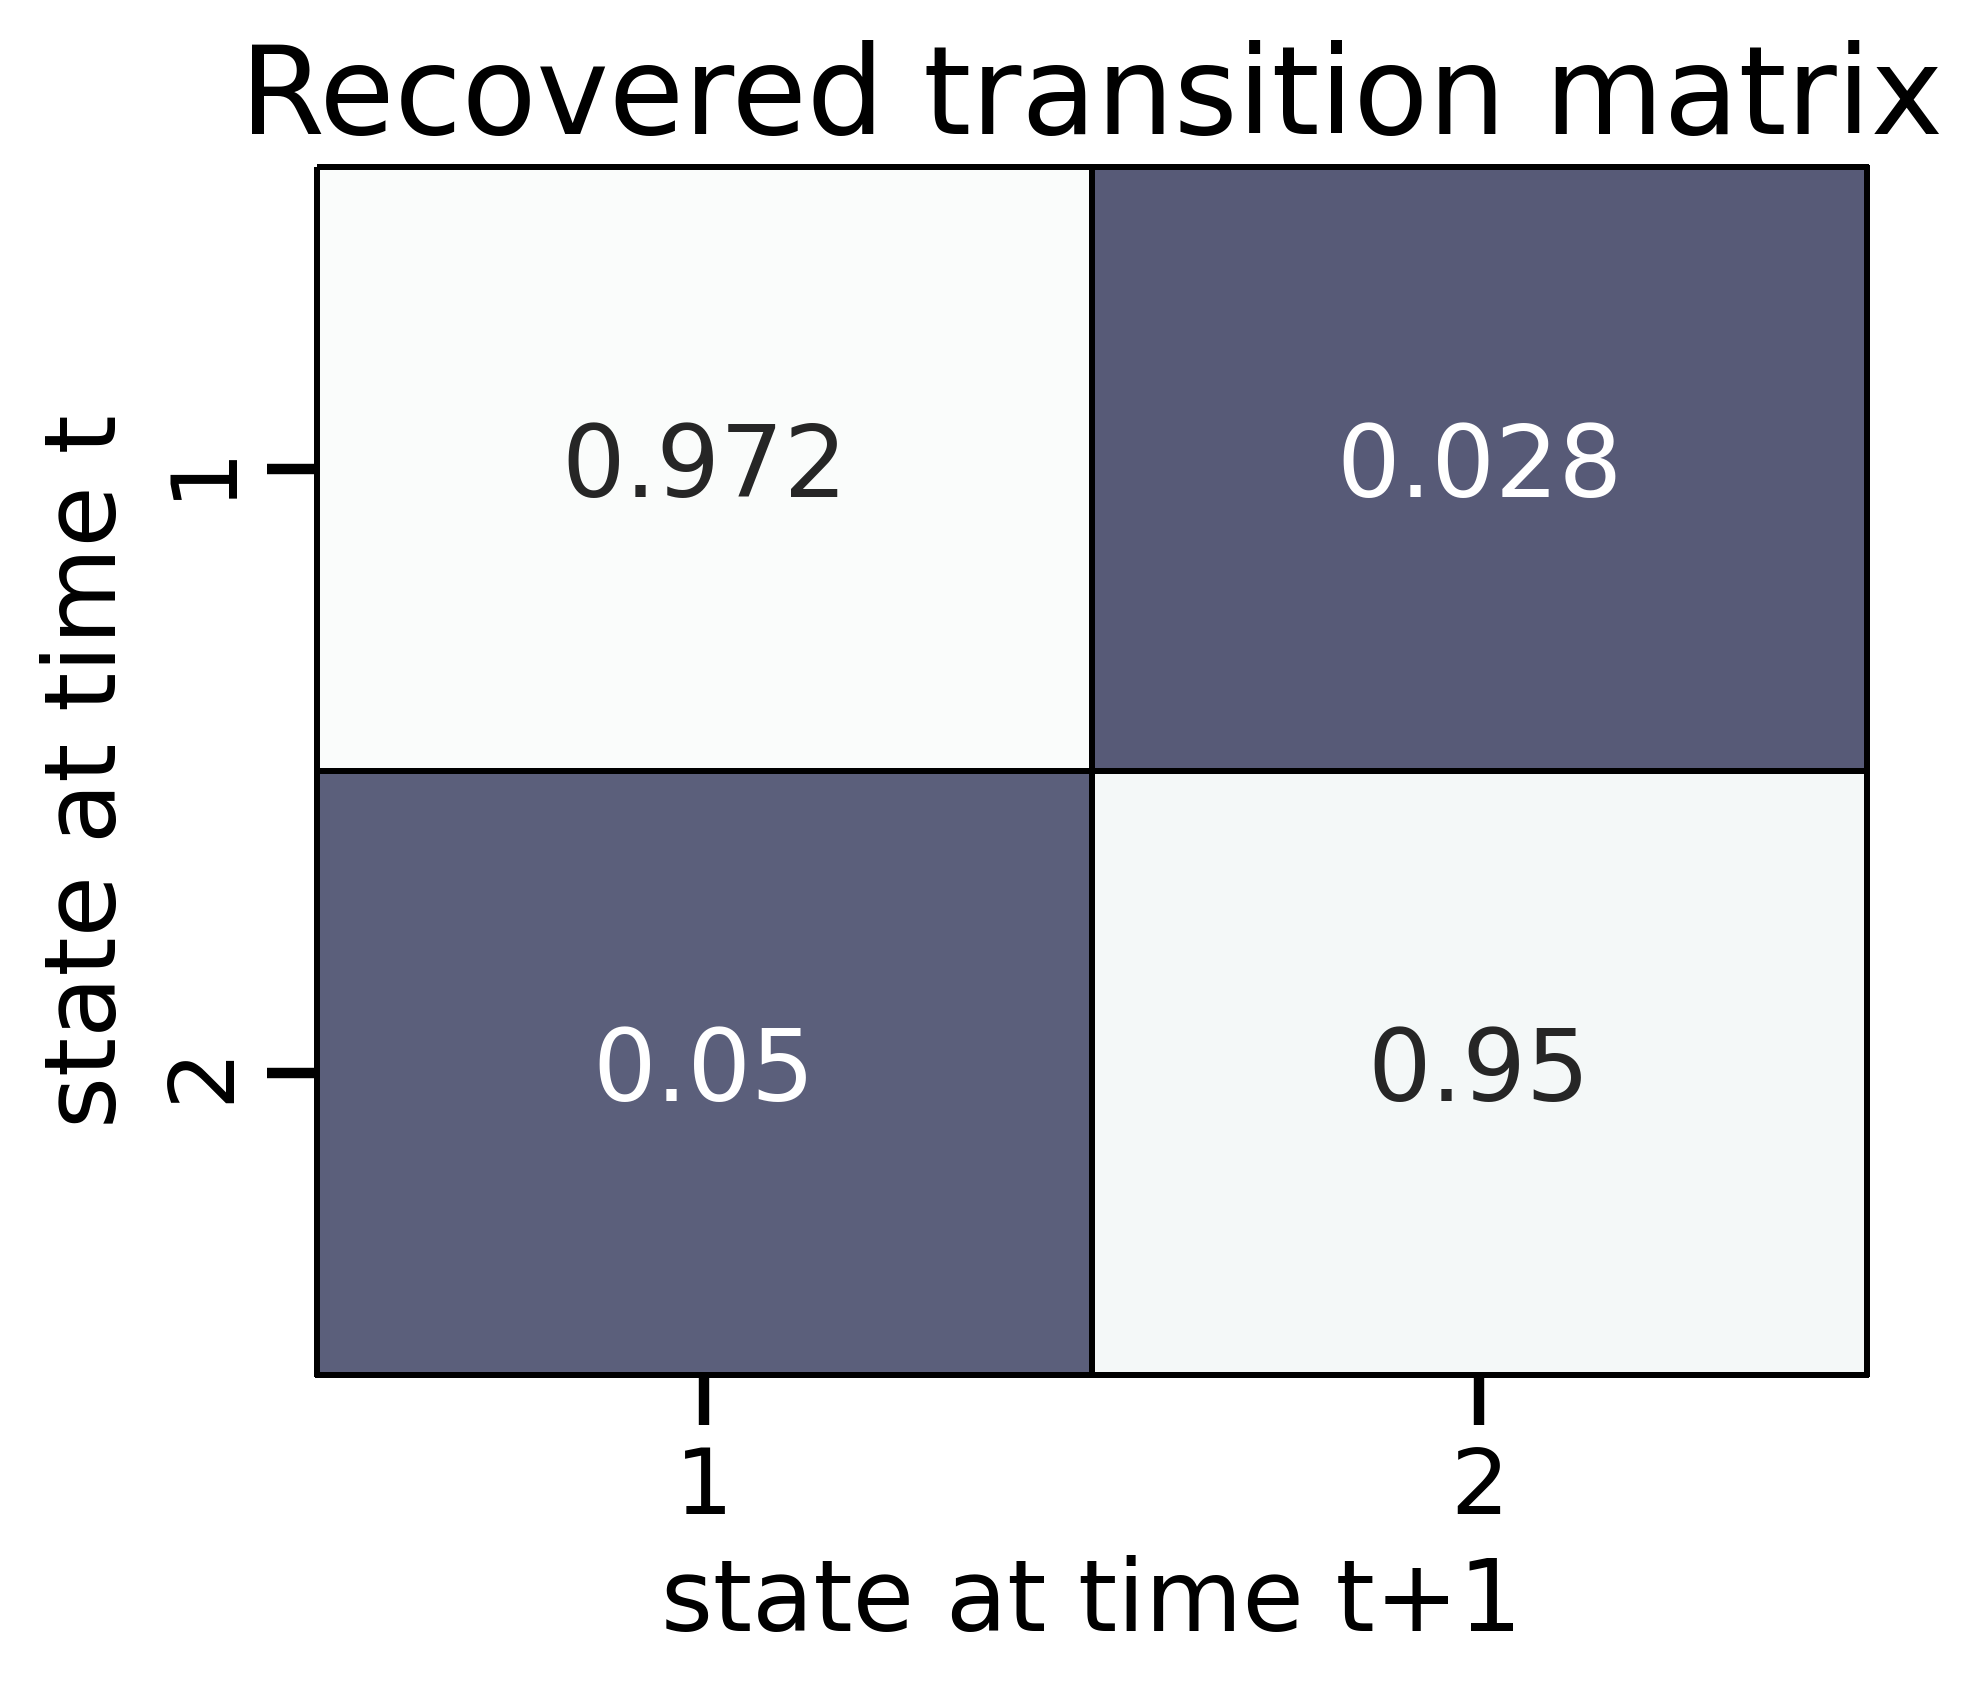

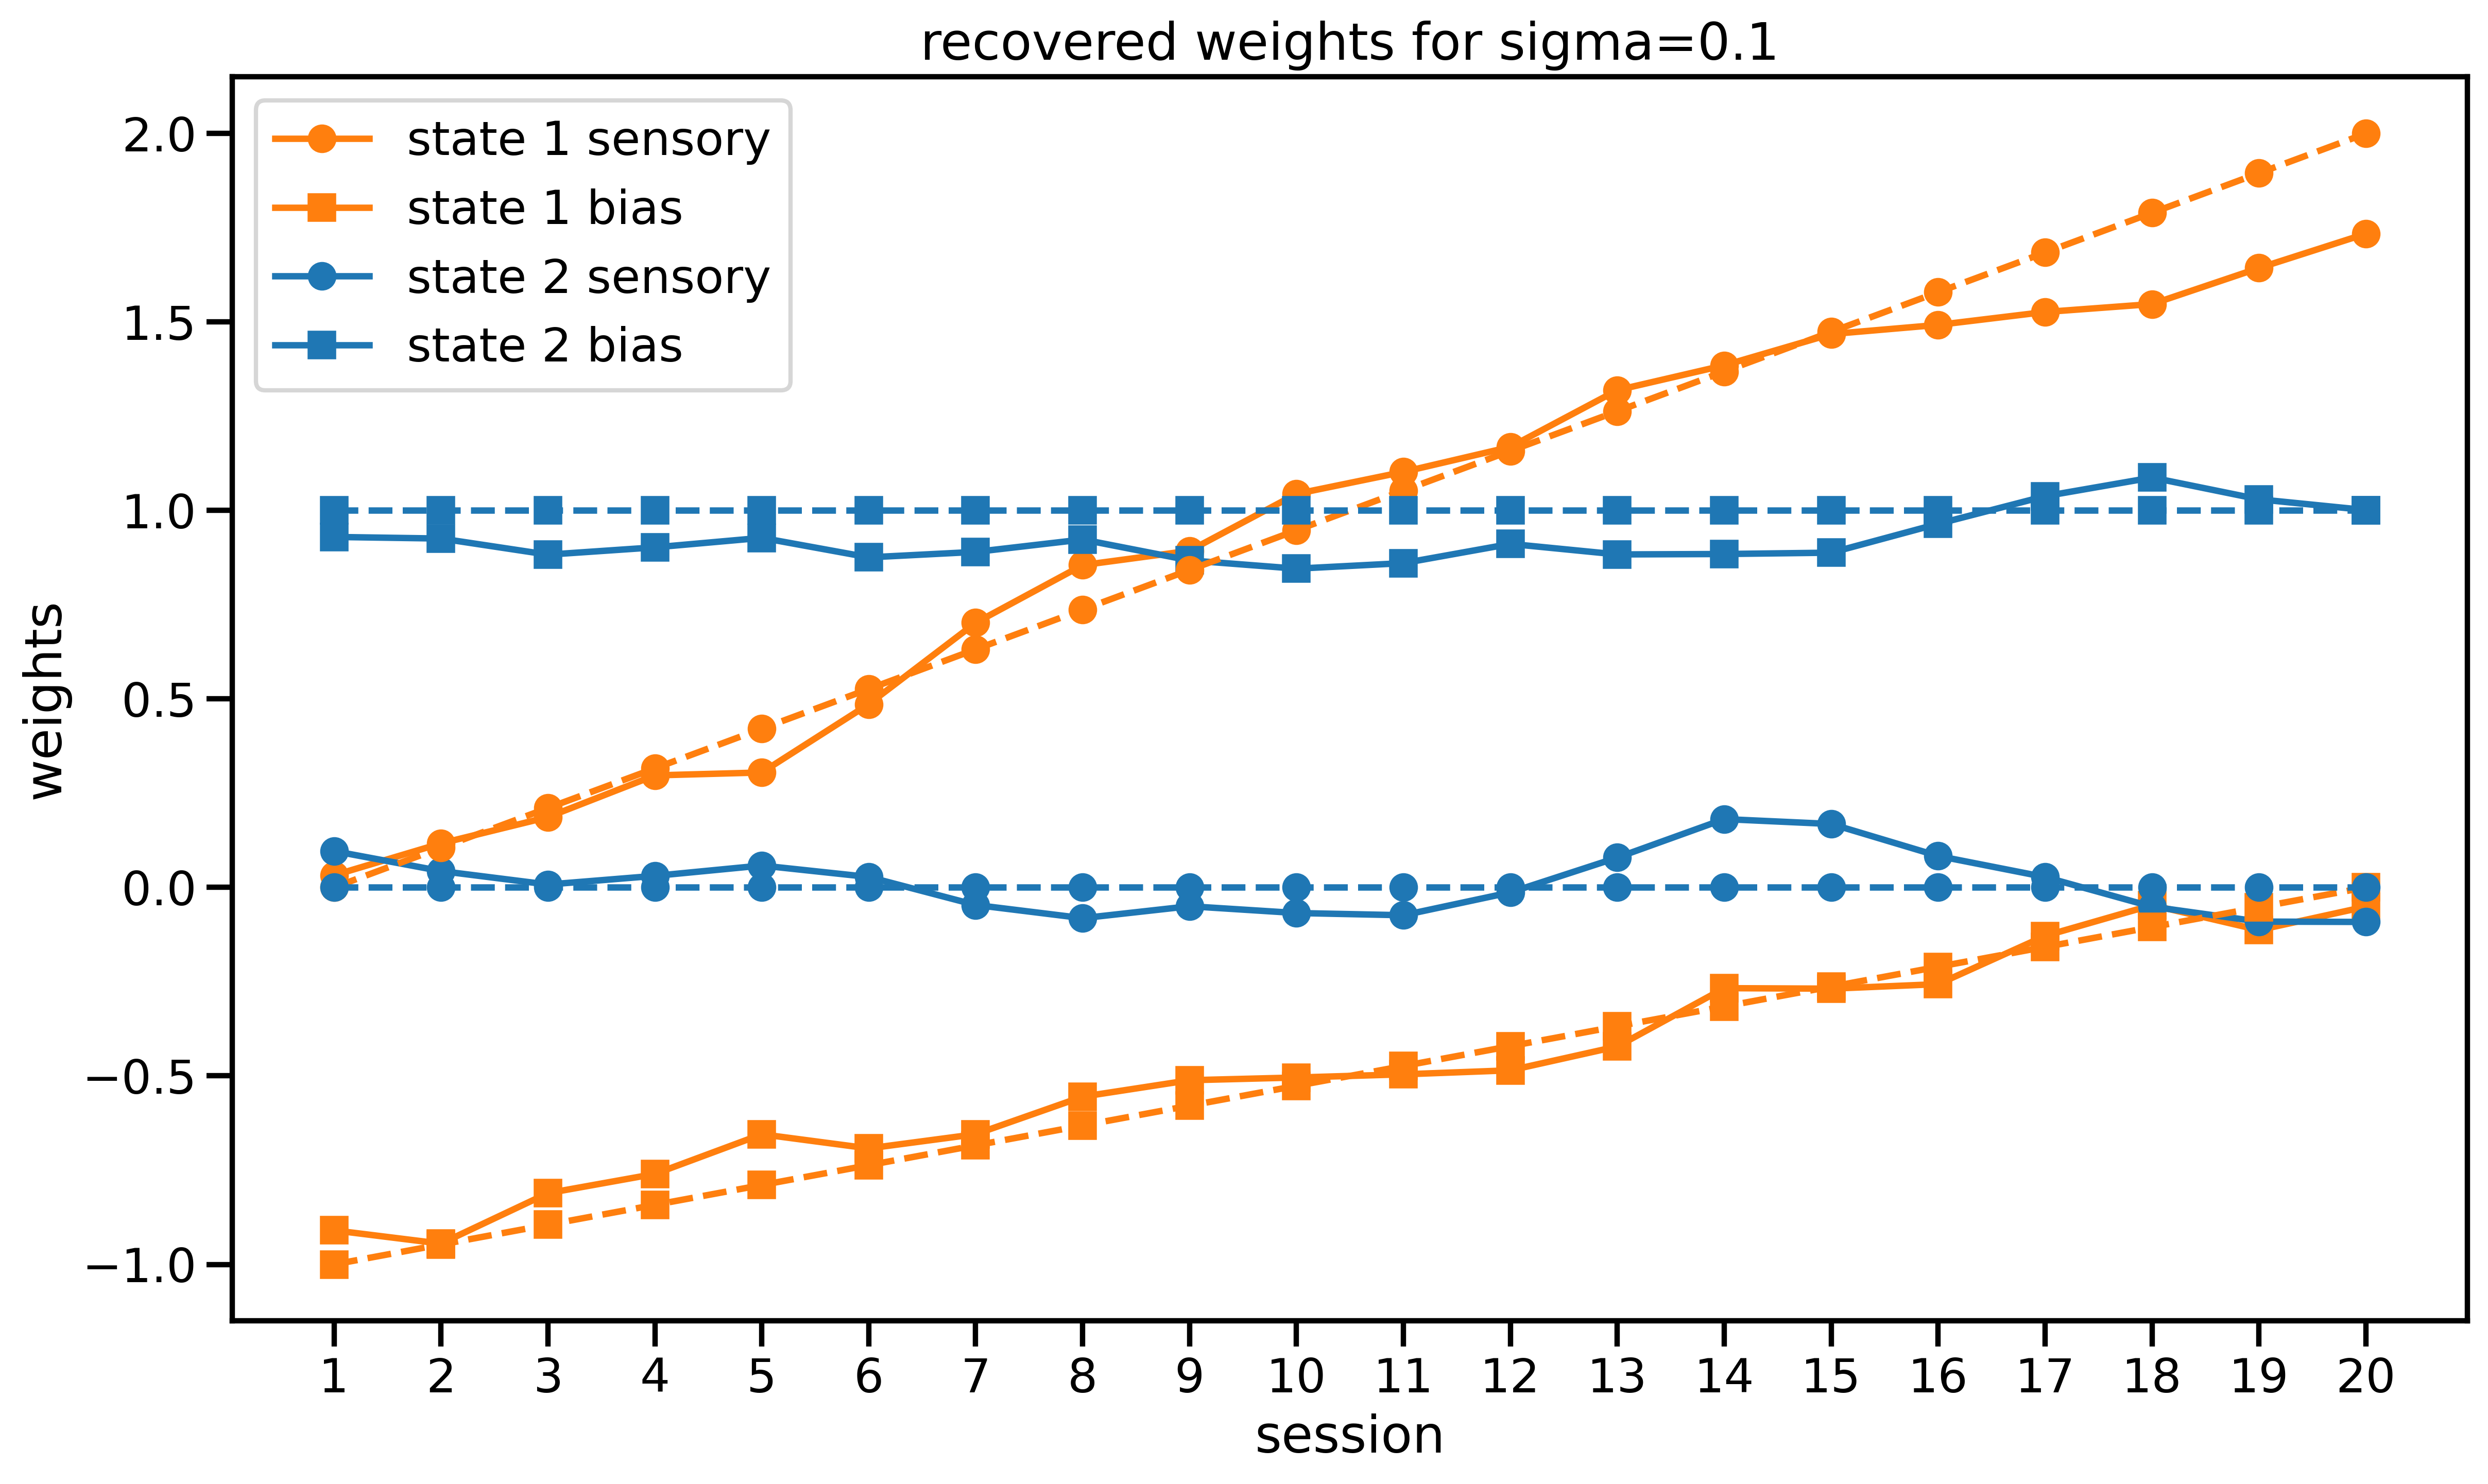

In [9]:
sigmaList = [0] + [2**x for x in list(np.arange(-10,-4,1,dtype=float))] + [2**x for x in list(np.arange(-4,1,0.5,dtype=float))] + [2**x for x in list(np.arange(1,8,2,dtype=float))]
allP = np.load(f'../data_M1/N={N}_{K}_P_CV_sigma1D_simulated_data.npy')
allW = np.load(f'../data_M1/N={N}_{K}_W_CV_sigma1D_simulated_data.npy')
bestIndSigma = 9 # best sigma across averaged testLl of folds
bestSigma = sigmaList[bestIndSigma]
print("Best sigma = ",bestSigma)
dglmhmmW = np.mean(allW, axis=0)[bestIndSigma] # averaging across folds and taking best sigma
globalP = np.mean(allP, axis=0)[bestIndSigma]

sortedStateInd = get_states_order(dglmhmmW, sessInd, stimCol=[1])
plot_transition_matrix(globalP, f'Recovered transition matrix', sortedStateInd=sortedStateInd)
plt.title('Recovered transition matrix', size=22)
# plt.savefig(f'../figures_M1/RecoveredP_2-state_sigma=0.1.png', bbox_inches='tight', dpi=400)
fig, axes = plt.subplots(1, figsize = (14,8), dpi=400)
plotting_weights(dglmhmmW, sessInd, axes=axes,  trueW=trueW, title=f'recovered weights for sigma={np.round(sigmaList[bestIndSigma], 1)}', save_fig=False, sortedStateInd=sortedStateInd)

In [46]:
indAlpha = 8
allP = np.load(f'../data_M2/N={N}_{K}_P_CV_alphas_simulated_data.npy')
allW = np.load(f'../data_M2/N={N}_{K}_W_CV_alphas_simulated_data.npy')
dGLM_HMM2 = dglm_hmm2.dGLM_HMM2(N,K,D,C)
alpha = 200
# x, y, _ = dGLM_HMM2.simulate_data(trueW, trueP, truepi, sessInd, save=True, title=f'N={N}_{K}-state_DirP-alpha={alpha}_')
x = np.load(f'../data_M2/N={N}_{K}-state_DirP-alpha={alpha}_x.npy')
y = np.load(f'../data_M2/N={N}_{K}-state_DirP-alpha={alpha}_y.npy')

P = np.mean(allP, axis=0)[indAlpha]
W = np.mean(allW, axis=0)[indAlpha]

In [44]:
# if x[stim] > 0 => correct side is 0 !!!
correctSide = np.zeros((N)).astype(int)
for t in range(0,N):
    if(x[t,1] < 0):
        correctSide[t] = 1

In [47]:
truepi = np.ones((K))/K
presentAll = np.ones((N))
phi = dGLM_HMM2.observation_probability(x, W)
gamma = dGLM_HMM2.get_posterior_latent(P, truepi, W, x, y, presentAll, sessInd)
p_correct, p_correct_states, p_correct_sessions, p_correct_states_sessions = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)


In [49]:
dGLMHMM = dglm_hmm2.dGLM_HMM2(N,K,4,2)
presentAll = np.ones((N)).astype(int)
pi = np.ones((K))/K
alpha = np.zeros((N,K))
performance_recompute = np.zeros((len(sessInd)-1))
correct = correctSide == y
for s in range(0,len(sessInd)-1):
    # E step - forward and backward passes given theta_old (= previous w and p)
    alphaSess, ctSess, llSess = dGLM_HMM2.forward_pass(y[sessInd[s]:sessInd[s+1]], presentAll, P[sessInd[s]:sessInd[s+1]], pi, phi[sessInd[s]:sessInd[s+1],:,:])
    alpha[sessInd[s]:sessInd[s+1]] = alphaSess
    performance_recompute[s] = np.mean(correct[sessInd[s]:sessInd[s+1]]) * 100

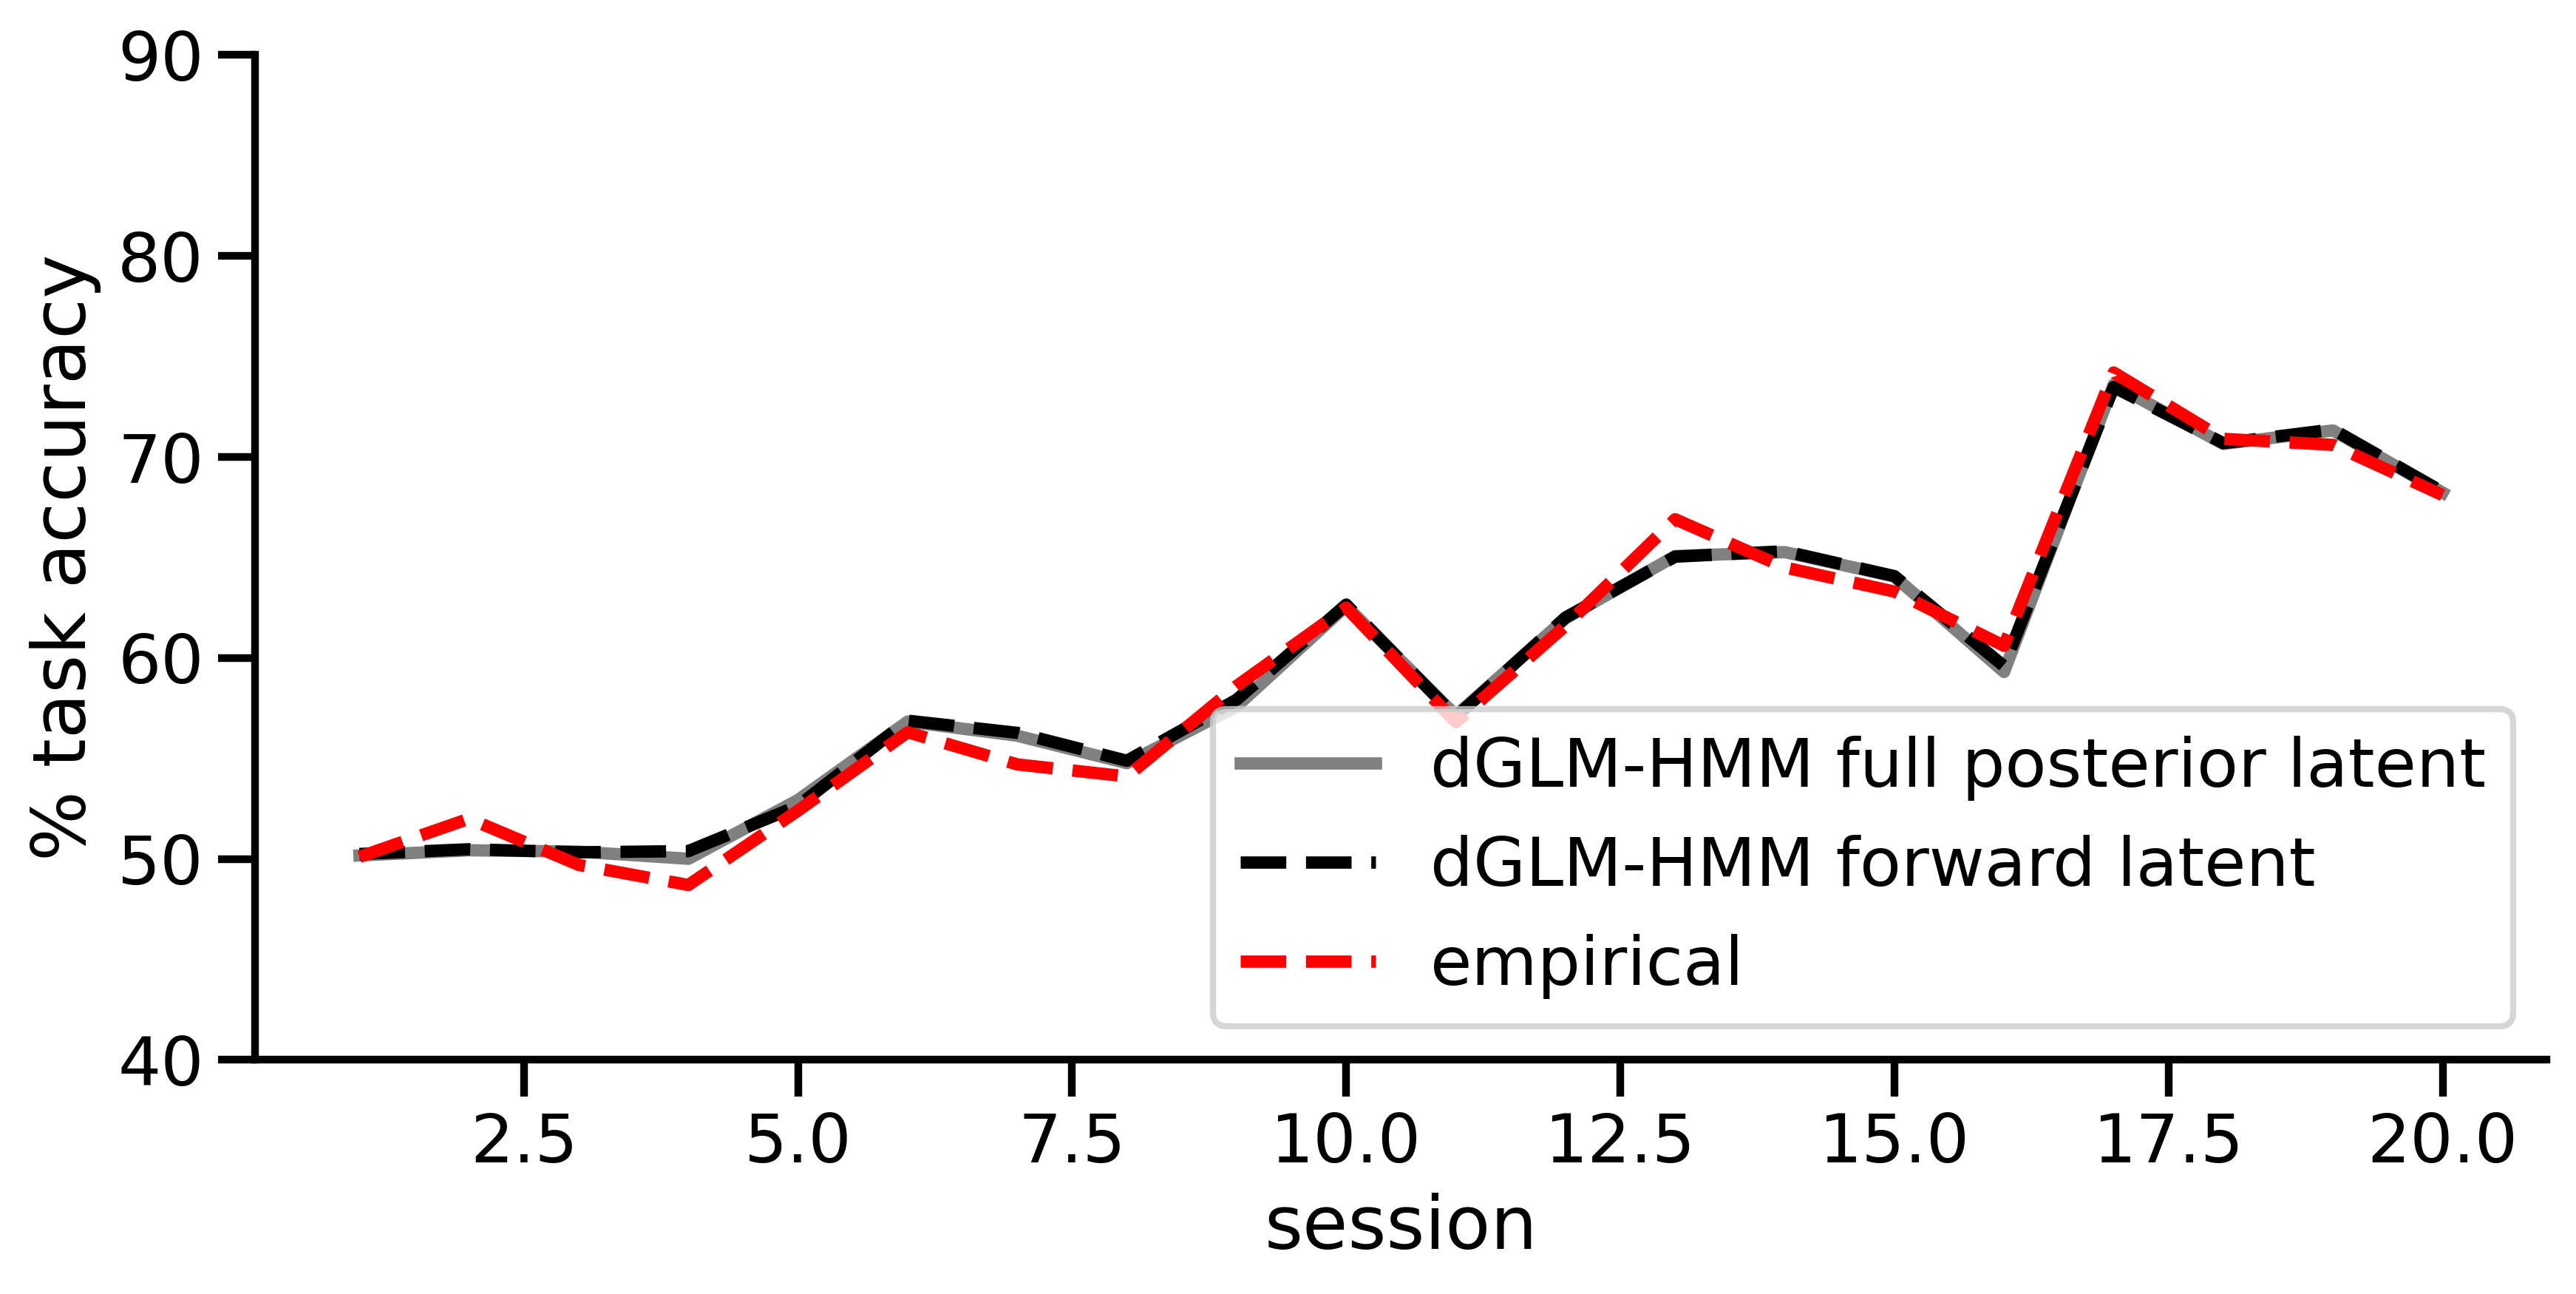

In [52]:
# empirical vs mixture vs model (full posterior latents) vs model (forward latents)
_, _, p_correct_sessions_full, p_correct_states_sessions_full = accuracy_states_sessions(gamma, phi, y, correctSide, sessInd)
_, _, p_correct_sessions_forward, p_correct_states_sessions_forward = accuracy_states_sessions(alpha, phi, y, correctSide, sessInd)

maxSess = 20
fig, axes = plt.subplots(1, figsize = (10,4.5), dpi=400) 
# dGLM-HMM overall accuracy
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallCorrect, axis=1)-np.nanstd(arrOverallCorrect, axis=1), np.nanmean(arrOverallCorrect, axis=1)+np.nanstd(arrOverallCorrect, axis=1), alpha=0.2, zorder=0, color="black")
axes.plot(range(1,maxSess+1), p_correct_sessions_full, color="gray", linewidth=3, label='dGLM-HMM full posterior latent', zorder=1)
# axes.plot(range(1,maxSess+1), p_correct_sessions_full, color="black", linewidth=3, label='dGLM-HMM full', zorder=1)
axes.plot(range(1,maxSess+1), p_correct_sessions_forward, color="black", linewidth=3, label='dGLM-HMM forward latent', zorder=1, ls='dashed')


# # Mixture overall accuracy
# # axes.fill_between(range(1,maxSess+1), np.nanmean(arrOverallMixtureCorrect, axis=1)-np.nanstd(arrOverallMixtureCorrect, axis=1), np.nanmean(arrOverallMixtureCorrect, axis=1)+np.nanstd(arrOverallMixtureCorrect, axis=1), alpha=0.2, zorder=0, color="gray")
# axes.plot(range(1,maxSess+1), np.nanmean(arrOverallMixtureCorrect, axis=1), color="gray", linewidth=3, label='mixture', zorder=1)

# empirical accuracy
# axes.fill_between(range(1,maxSess+1), np.nanmean(arrEmpiricalCorrect, axis=1)-np.nanstd(arrEmpiricalCorrect, axis=1), np.nanmean(arrEmpiricalCorrect, axis=1)+np.nanstd(arrEmpiricalCorrect, axis=1), alpha=0.2, zorder=0, color="red")
# axes.plot(range(1,maxSess+1), performance_psytrack, color="red", linewidth=3, label='empirical old', zorder=1)
axes.plot(range(1,maxSess+1), performance_recompute, color="red", linewidth=3, label='empirical', zorder=1, ls='dashed')


axes.set_ylabel('% task accuracy')
axes.set_xlabel('session')
# axes.set_yticks([40,60,80])
axes.set_ylim(40,90)
axes.axhline(0.5, color="black", linestyle="--", lw=1, alpha=0.3, zorder=0)
axes.spines[['right', 'top']].set_visible(False)
axes.legend(loc='lower right')
# axes.set_title('Model vs Empirical Performance' ,size=22, pad=20)
# plt.savefig(f'../figures/Accuracy_Model-Empirical-Mixture_allAnimals', bbox_inches='tight', dpi=400)
